In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.aw_hermite.setup_aw_hermite import SimulationSetupHermite
from operators.poisson_solver import gmres_solver
from operators.aw_hermite.aw_hermite_operators import aw_psi_hermite

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Enable LaTeX rendering
matplotlib.rcParams['text.usetex'] = True

# Hermite: linear advection $\partial_{t} f + v \partial_{x} f = 0$

In [4]:
setup = SimulationSetupHermite(Nx=101,
                               Nv=400,
                               epsilon=1,
                               alpha_e=np.sqrt(2),
                               alpha_i=np.sqrt(2 / 1836),
                               u_e=0,
                               u_i=0,
                               L=2 * np.pi,
                               dt=1e-2,
                               T0=0,
                               T=20,
                               nu=0,
                               u_tol=np.inf,
                               alpha_tol=np.inf)

In [5]:
# ions (unperturbed)
C0_ions = np.ones(setup.Nx) / setup.alpha_i

In [6]:
# velocity and spatial grid for plotting purposes
v = np.linspace(-5, 5, int(1e3), endpoint=True)
x = np.linspace(0, setup.L, setup.Nx+1, endpoint=True)

# simulation results

In [7]:
skip = 1
# load the simulation results
# save results
sol_midpoint_u = np.load("../../data/aw_hermite/advection/sol_u_Nv_" + str(setup.Nv) + "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
sol_midpoint_t = np.load("../../data/aw_hermite/advection/sol_t_Nv_" + str(setup.Nv) + "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

dt = 0.01 * skip

# print simulation dimensions
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(40400, 2001)
(2001,)


In [8]:
runtime = np.load("../../data/aw_hermite/advection/sol_runtime_Nv_" + str(setup.Nv) + "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
runtime

array([2039.963044  ,  565.28603578])

In [9]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((setup.Nv,  setup.Nx + 1, len(sol_midpoint_t)))

# unwind the flattening to solve the Vlasov-Poisson system
# electrons
state_e_midpoint[:, :-1, :] = np.reshape(sol_midpoint_u, (setup.Nv, setup.Nx, len(sol_midpoint_t)))
# periodicity enforced
state_e_midpoint[:, -1, :] = state_e_midpoint[:, 0, :]

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_2022/3684570841.py:2: RuntimeWarning: divide by zero encountered in log10
  pos = ax.pcolormesh(np.arange(setup.Nv), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_midpoint[:, :-1, :], axis=1, norm="forward"))[:, 1, :]).T, vmin=-6, vmax=-1)


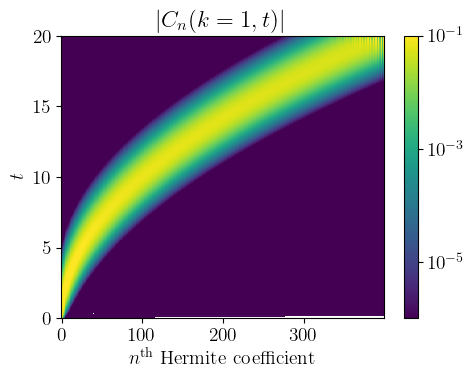

In [10]:
fig, ax = plt.subplots(figsize=(5, 4))
pos = ax.pcolormesh(np.arange(setup.Nv), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_midpoint[:, :-1, :], axis=1, norm="forward"))[:, 1, :]).T, vmin=-6, vmax=-1)
cbar = fig.colorbar(pos)

cbar.set_ticks([-1, -3, -5])
cbar.set_ticklabels(['$10^{-1}$', '$10^{-3}$', '$10^{-5}$'])

ax.set_ylabel("$t$")
ax.set_xlabel("$n^{\mathrm{th}}$ Hermite coefficient")
ax.set_title("$|C_{n}(k=1, t)|$")
plt.tight_layout()
plt.savefig("../../figures/hermite/weak_landau/hermite_evolution.png", dpi=300)

In [11]:
X, V = np.meshgrid(x, v)

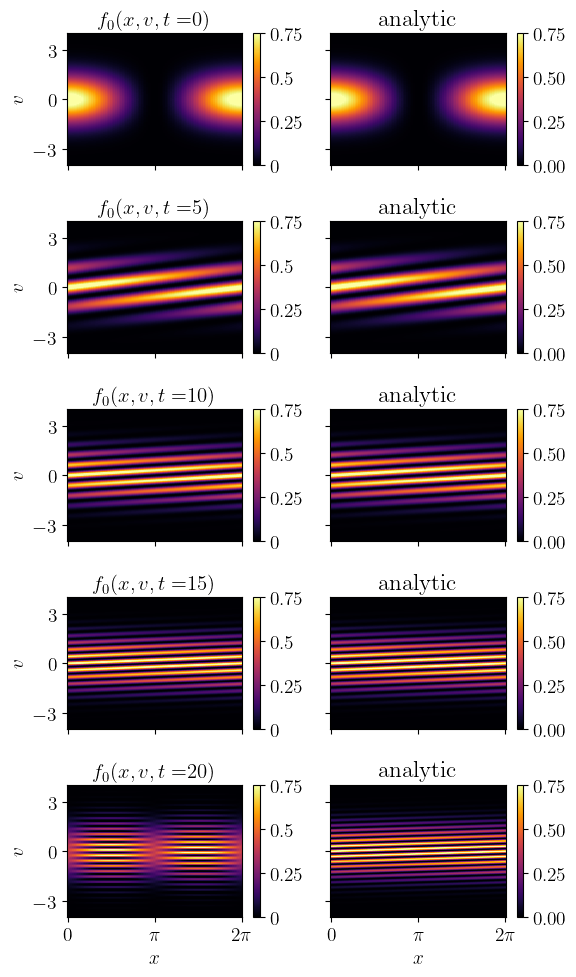

In [12]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(6, 10), sharex=True, sharey=True)

levels = np.linspace(-0.05, 0.4, 50)

for tt, ii in enumerate([0, int(1*len(sol_midpoint_t)//4), int(2*len(sol_midpoint_t)//4), int(3*len(sol_midpoint_t)//4),  -1]):
    ii = int(ii)
    distribution1 = np.zeros((len(x), len(v)))
    for jj in range(setup.Nv):
        distribution1 += np.outer(state_e_midpoint[jj, :, ii], aw_psi_hermite(v=v, u_s=setup.u_e[-1], alpha_s=setup.alpha_e[-1], n=jj))
    pos1 = ax[tt, 0].pcolormesh(x, v, distribution1.T, cmap="inferno", vmin=0, vmax=0.75)
    pos2 = ax[tt, 1].pcolormesh(x, v, 
                                1/np.sqrt(np.pi) * np.exp(-0.5 * V**2) * (1 + setup.epsilon*np.cos((X - V*sol_midpoint_t[ii]))) / setup.alpha_e[-1],
                                cmap="inferno",  vmin=0, vmax=0.75)
    ax[tt, 0].set_yticks([-3, 0, 3, 6])
    ax[tt, 0].set_ylim(-4, 4)
    ax[tt, 0].set_ylabel(r"$v$")
    cbar = fig.colorbar(pos2)
    cbar = fig.colorbar(pos1, ticks=[0, 0.25, 0.5, 0.75])
    cbar.ax.set_yticklabels(["0", "0.25", "0.5", "0.75"])

    ax[tt, 0].set_title('$f_{0}(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", fontsize=15)
    ax[tt, 1].set_title("analytic")
    
ax[tt, 0].set_xlabel("$x$")
ax[tt, 0].set_xticks([0, np.pi, 2*np.pi])
ax[tt, 0].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[tt, 1].set_xlabel("$x$")
ax[tt, 1].set_xticks([0, np.pi, 2*np.pi])
ax[tt, 1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])

plt.tight_layout()
plt.savefig("../../figures/hermite/advection/advection_hermite.png", dpi=600)

In [13]:
error = np.zeros(len(sol_midpoint_t))
for ii in range(len(sol_midpoint_t)):
    distribution = np.zeros((len(x), len(v)))
    for jj in range(setup.Nv):
        distribution += np.outer(state_e_midpoint[jj, :, ii], aw_psi_hermite(v=v, u_s=setup.u_e[-1], alpha_s=setup.alpha_e[-1], n=jj))
    analytic = 1/np.sqrt(np.pi) * np.exp(-0.5 * V**2) * (1 + setup.epsilon*np.cos((X - V*sol_midpoint_t[ii]))) / setup.alpha_e[-1]
    numerical = distribution
    error[ii] = np.linalg.norm(numerical - analytic.T, ord=2)

In [14]:
np.save("../../data/aw_hermite/advection/error_L2_Nv_" + str(setup.Nv) + 
        "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy", error)

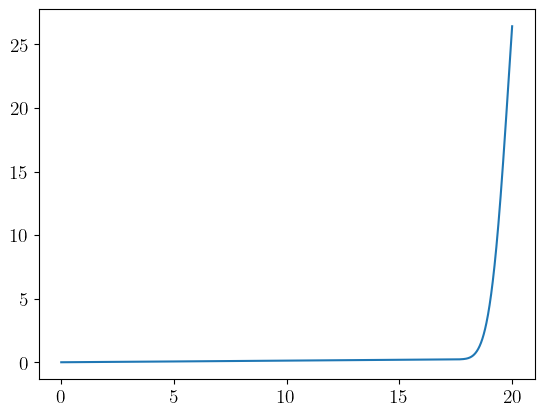

In [16]:
plt.plot(sol_midpoint_t, error)